In [4]:
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer

%matplotlib inline
import matplotlib.pyplot as plt

import shutil
import os

from sklearn.model_selection import train_test_split
import time

In [5]:
train_data = np.load('datasets/data_autoencoder_train.npz')
eval_data = np.load('datasets/data_autoencoder_eval.npz')

In [6]:
RANDOM_STATE = 0
X_train = np.asarray(shuffle(train_data['x_ae_train'], random_state=RANDOM_STATE), dtype=np.float32) / 255
X_eval = np.asarray(shuffle(eval_data['x_ae_eval'], random_state=RANDOM_STATE), dtype=np.float32) / 255

In [7]:
def cae_model_fn(features, labels, mode, params):
    if params == None:
        learning_rate = 0.001
    else:
        learning_rate = params['learning_rate']
    X_origin = tf.reshape(features['x'], [-1, 28, 28, 1])
    
    conv1 = tf.layers.conv2d(
        inputs=X_origin,
        filters=32,
        kernel_size=5,
        strides=2,
        padding='same',
        activation=tf.nn.relu,
        kernel_initializer=xavier_initializer(seed=0),
        name='conv1'
    )
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        kernel_size=5,
        strides=2,
        padding='same',
        activation=tf.nn.relu,
        kernel_initializer=xavier_initializer(seed=1)
    )
    conv3 = tf.layers.conv2d(
        inputs=conv2,
        filters=2,
        kernel_size=3,
        strides=1,
        padding='same',
        activation=tf.nn.relu,
        kernel_initializer=xavier_initializer(seed=2)
    )
    deconv1 = tf.layers.conv2d_transpose(
        inputs=conv3,
        filters=64,
        kernel_size=3,
        strides=1,
        padding='same',
        activation=tf.nn.relu,
        kernel_initializer=xavier_initializer(seed=3)
    )
    deconv2 = tf.layers.conv2d_transpose(
        inputs=deconv1,
        filters=32,
        kernel_size=5,
        strides=2,
        padding='same',
        activation=tf.nn.relu,
        kernel_initializer=xavier_initializer(seed=4)
    )
    deconv3 = tf.layers.conv2d_transpose(
        inputs=deconv2,
        filters=1,
        kernel_size=5,
        strides=2,
        padding='same',
        kernel_initializer=xavier_initializer(seed=5)
    )
    
    X_reconstruct = deconv3
    predictions = {
        'predictions': X_reconstruct
    }
    loss = tf.losses.mean_squared_error(X_origin, X_reconstruct)
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    if mode == tf.estimator.ModeKeys.TRAIN:
        #optimizer = tf.train.MomentumOptimizer(momentum=0.9, learning_rate=learning_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss)

In [8]:
def train_eval_cae(X_train, X_eval, learning_rate, batch_size=64, steps=20000):
    model_dir = f'cae_model_{learning_rate}'
    # remove old models
    if os.path.exists(model_dir):
        shutil.rmtree(model_dir)
    
    mnist_cae = tf.estimator.Estimator(
        model_fn=cae_model_fn,
        model_dir=model_dir,
        params={'learning_rate': learning_rate})
    
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': X_train},
        batch_size=batch_size,
        num_epochs=None,
        shuffle=False)
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': X_eval},
        num_epochs=1,
        shuffle=False)
    trainset_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': X_train},
        num_epochs=1,
        shuffle=False)
    start_ts = time.time()
    mnist_cae.train(
        input_fn=train_input_fn,
        steps=steps)
    end_ts = time.time()
    trainset_score = mnist_cae.evaluate(input_fn=trainset_eval_input_fn)
    eval_score = mnist_cae.evaluate(input_fn=eval_input_fn)
    print(f'Training time (seconds): {end_ts - start_ts}')
    print('Performance on training set: ')
    print(trainset_score)
    print('Performance on validation/test set: ')
    print(eval_score)
    return mnist_cae, eval_score['loss']

In [9]:
def cae_cv(X, n_splits, learning_rates):
    for learning_rate in learning_rates:
        losses = []
        for _ in range(0, n_splits):
            X_train, X_valid = train_test_split(X, test_size=0.2)
            model, loss = train_eval_cae(X_train, X_valid, learning_rate)
            losses.append(loss)
        print(f'Learning rate = {learning_rate}, Average loss: {np.mean(losses)}')

In [10]:
def plot_feature_maps(kernels):
    fig, axes = plt.subplots(4, 8)
    fig.suptitle('Feature maps of the 1st layer')
    for i in range(0, 4):
        for j in range(0, 8):
            kernel = kernels[:,:,0, 8*i+j].reshape([5, 5])
            axes[i, j].imshow(kernel)
            axes[i, j].axis('off')
    plt.show()

def plot_reconstructed_images(X_eval, X_pred, n):
    fig, axes = plt.subplots(n, 4)
    fig.suptitle('Column 1,3: original images. Column 2, 4: reconstructed images')
    for i in range(0, n):
        axes[i, 0].imshow(X_eval[2*i], cmap='gray')
        axes[i, 1].imshow(X_pred[2*i], cmap='gray')
        axes[i, 2].imshow(X_eval[2*i+1], cmap='gray')
        axes[i, 3].imshow(X_pred[2*i+1], cmap='gray')
        for j in range(0, 4):
            axes[i, j].axis('off')
    plt.show()

In [ ]:
# find the optimal learning rate using cross validation
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]
cae_cv(X_train, 5, learning_rates)

In [ ]:
# train the final model using the optimal learning rate
model, loss = train_eval_cae(X_train, X_eval, 0.001)

In [11]:
# evaluate model
model_dir = 'cae_model_0.001'
learning_rate = 0.001
model = tf.estimator.Estimator(
    model_fn=cae_model_fn,
    model_dir=model_dir,
    params={'learning_rate': learning_rate})
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': X_eval},
    num_epochs=1,
    shuffle=False
)
pred_res = model.predict(input_fn=predict_input_fn)
X_pred = [x['predictions'].reshape([28,28]) for x in pred_res]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'cae_model_0.001', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002778224E7F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cae_model_0.001\model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


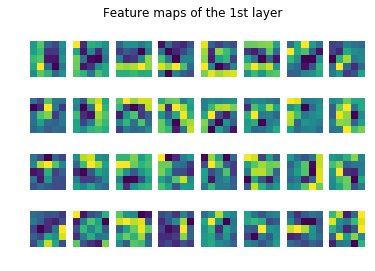

In [12]:
kernels = model.get_variable_value('conv1/kernel')
plot_feature_maps(kernels)

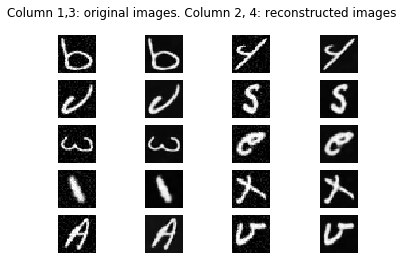

In [14]:
plot_reconstructed_images(X_eval, X_pred, 5)